## Import

In [1]:
import os
import sys
import pathlib
import warnings
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm

import seaborn as sns

import gymnasium as gym

from transformers import LlamaForCausalLM, AutoTokenizer, AutoModel
from bertviz import head_view, model_view
from IPython.display import display, HTML

from llmicl.rl_helpers.rl_utils import load_offline_dataset, create_env
from llmicl.legacy.data.serialize import serialize_arr, SerializerSettings

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


# Load data

In [156]:
env_name = 'HalfCheetah'
context_length = 100
dataset = 'expert'  # 'expert_80k_20k'
episode = 2

_, n_observations, n_actions = create_env(env_name)

data_path = f"/home/abenechehab/datasets/{env_name}/{dataset}/X_test.csv"
X = load_offline_dataset(path=data_path)

# find episodes beginnings
restart_index = n_observations+n_actions+1
restarts = X[:, restart_index]
episode_starts = np.where(restarts)[0]

print(f"episode starts: {episode_starts}")

init_index = episode_starts[episode] + 200

time_series = X[init_index:init_index+context_length, :n_observations]

episode starts: [    0     1     2 ... 18997 18998 18999]


/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(


# Visualize attention matrices

## serialize data

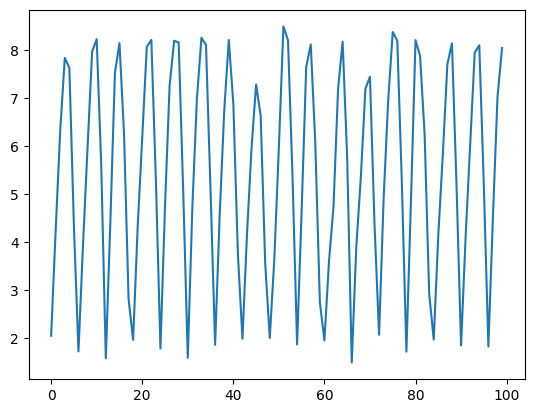

'205,426,634,784,763,433,173,395,599,797,823,560,158,442,752,815,627,282,197,432,618,807,821,528,179,475,725,820,816,505,159,472,699,826,811,506,186,456,673,821,689,376,199,416,597,729,664,356,200,365,598,850,821,536,187,467,765,812,606,275,195,359,475,720,818,575,150,391,536,720,745,437,207,491,695,838,820,524,172,486,821,788,625,293,197,414,584,771,814,520,185,411,603,795,810,518,183,454,703,805,'

In [3]:
rescale_factor = 7.0
up_shift = 1.5
dim = 5
# ------------------ serialize_gaussian ------------------
settings = SerializerSettings(base=10, prec=2, signed=True, time_sep=',', bit_sep='', minus_sign='-', fixed_length=False, max_val = 10)

ts_min = time_series[:, dim].min()
ts_max = time_series[:, dim].max()

rescaled_array = (time_series[:, dim] - ts_min) / (
    ts_max - ts_min
) * rescale_factor + up_shift

plt.figure()
plt.plot(rescaled_array)
plt.show()

full_series = serialize_arr(rescaled_array, settings)

full_series

## Load LLM

In [4]:
# Load the model
model_name = "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = LlamaForCausalLM.from_pretrained(model_name, output_attentions=True, device_map="auto")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Bertviz

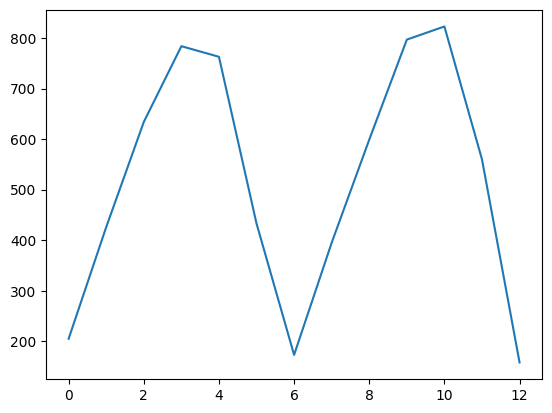

In [88]:
plt.plot([int(s) if s else None for s in full_series[:51].split(',')])

In [128]:
constant_series = ''
for _ in range(25):
    constant_series += '586'

jump_series = ''
for i in range(25):
    jump_series += '322,' if i<12 else '754,'

two_jump_series = ''
for i in range(25):
    if i < 6:
        two_jump_series += '322,'
    elif i < 12:
        two_jump_series += '754,'
    elif i < 18:
        two_jump_series += '322,'
    else:
        two_jump_series += '754,'

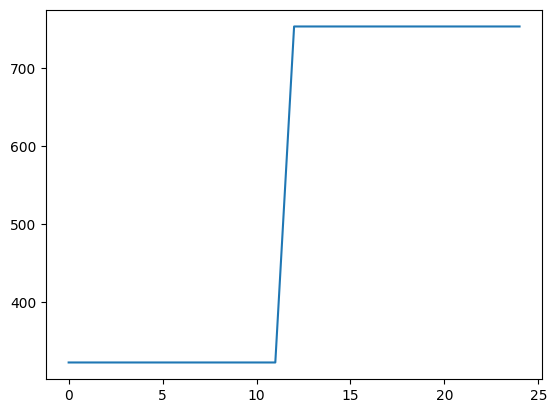

In [136]:
plt.plot([int(s) if s else None for s in jump_series.split(',')])

## head view

In [155]:
test_sentence = "A man has a daughter The girl plays football All football players are rich Some men are rich as well" 
fibonacci = "1,1,2,3,5,8,13,21,34,55,89"
inputs = tokenizer.encode(full_series[:151].replace(',', ''), return_tensors='pt')
# inputs = tokenizer.encode(jump_series.replace(',', ''), return_tensors='pt')

# Run the model
outputs = model(inputs)
attention = outputs[-1]  # Output includes attention weights when output_attentions=True
tokens = tokenizer.convert_ids_to_tokens(inputs[0][1:])

# Visualize the complete model view
# head_view(attention, tokens, html_action='return')
# display(HTML(html_head_view.data))

'''
html_model_view = model_view(attention, tokens, html_action='return')
display(HTML(html_model_view.data))

# Visualize the view just for certain layers if the browser can't display the whole
# Shorter inputs are easier to display
layers = [1]
html_head_view = head_view(attention, tokens, html_action='return', include_layers=layers)
display(HTML(html_head_view.data))

html_model_view = model_view(attention, tokens, html_action='return', include_layers=layers)
display(HTML(html_model_view.data))
'''

new_attention = ()
for att_matrix in attention:
    new_attention += (att_matrix[:,:,1:,1:],)

layers = [0]
head_view(new_attention, tokens, include_layers=layers)

<IPython.core.display.Javascript object>

## most probable next token

In [138]:
good_tokens_str = []
# for num in range(100, n_states-100):
for num in range(1000):
    good_tokens_str.append(str(num))
good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]

max_prob_token = outputs['logits'][0,-1, good_tokens].argmax().item()
print(max_prob_token)

754


## model view

In [ ]:
model_view(new_attention, tokens)

## Ambroise fn to plot attention

In [92]:
def plot_attention_matrices(
    attention_matrices,
    save=False,
    format="png",
    dpi=100,
):
    # Plot settings
    c = 4
    figsize = (8 * c, 4 * c - 0.5)
    ratio = 10
    ratios = [ratio] * 8
    fig, axes = plt.subplots(
        nrows=4,
        ncols=8,
        sharex=False,
        sharey=False,
        figsize=figsize,
        gridspec_kw={"width_ratios": ratios},
    )
    cmap = sns.cubehelix_palette(rot=0.2, as_cmap=True)
    vmin = 0
    vmax = 1

    # Plot attention matrices
    for i in range(4):
        for j in range(8):
            ax = axes[i, j]
            index = j + 8 * i
            sns.heatmap(
                attention_matrices[index],
                ax=ax,
                linewidths=0,
                square=True,
                cbar=False,
                cmap=cmap,
                xticklabels=False,
                yticklabels=False,
                robust=False,
                vmin=vmin,
                vmax=vmax,
            )

    # Add colorbar at the right side of the plot
    cbar_ax = fig.add_axes([1, 0.1, 0.02, 0.8])
    fig.colorbar(axes[-1, -1].collections[0], cax=cbar_ax, ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

    plt.tight_layout()

    # Save or show the plot
    if save:
        figname = f"attention_matrices.{format}"
        plt.savefig(figname, format=format, bbox_inches="tight", dpi=dpi)
    plt.show()

### single layer

/tmp/ipykernel_2113408/1216259471.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


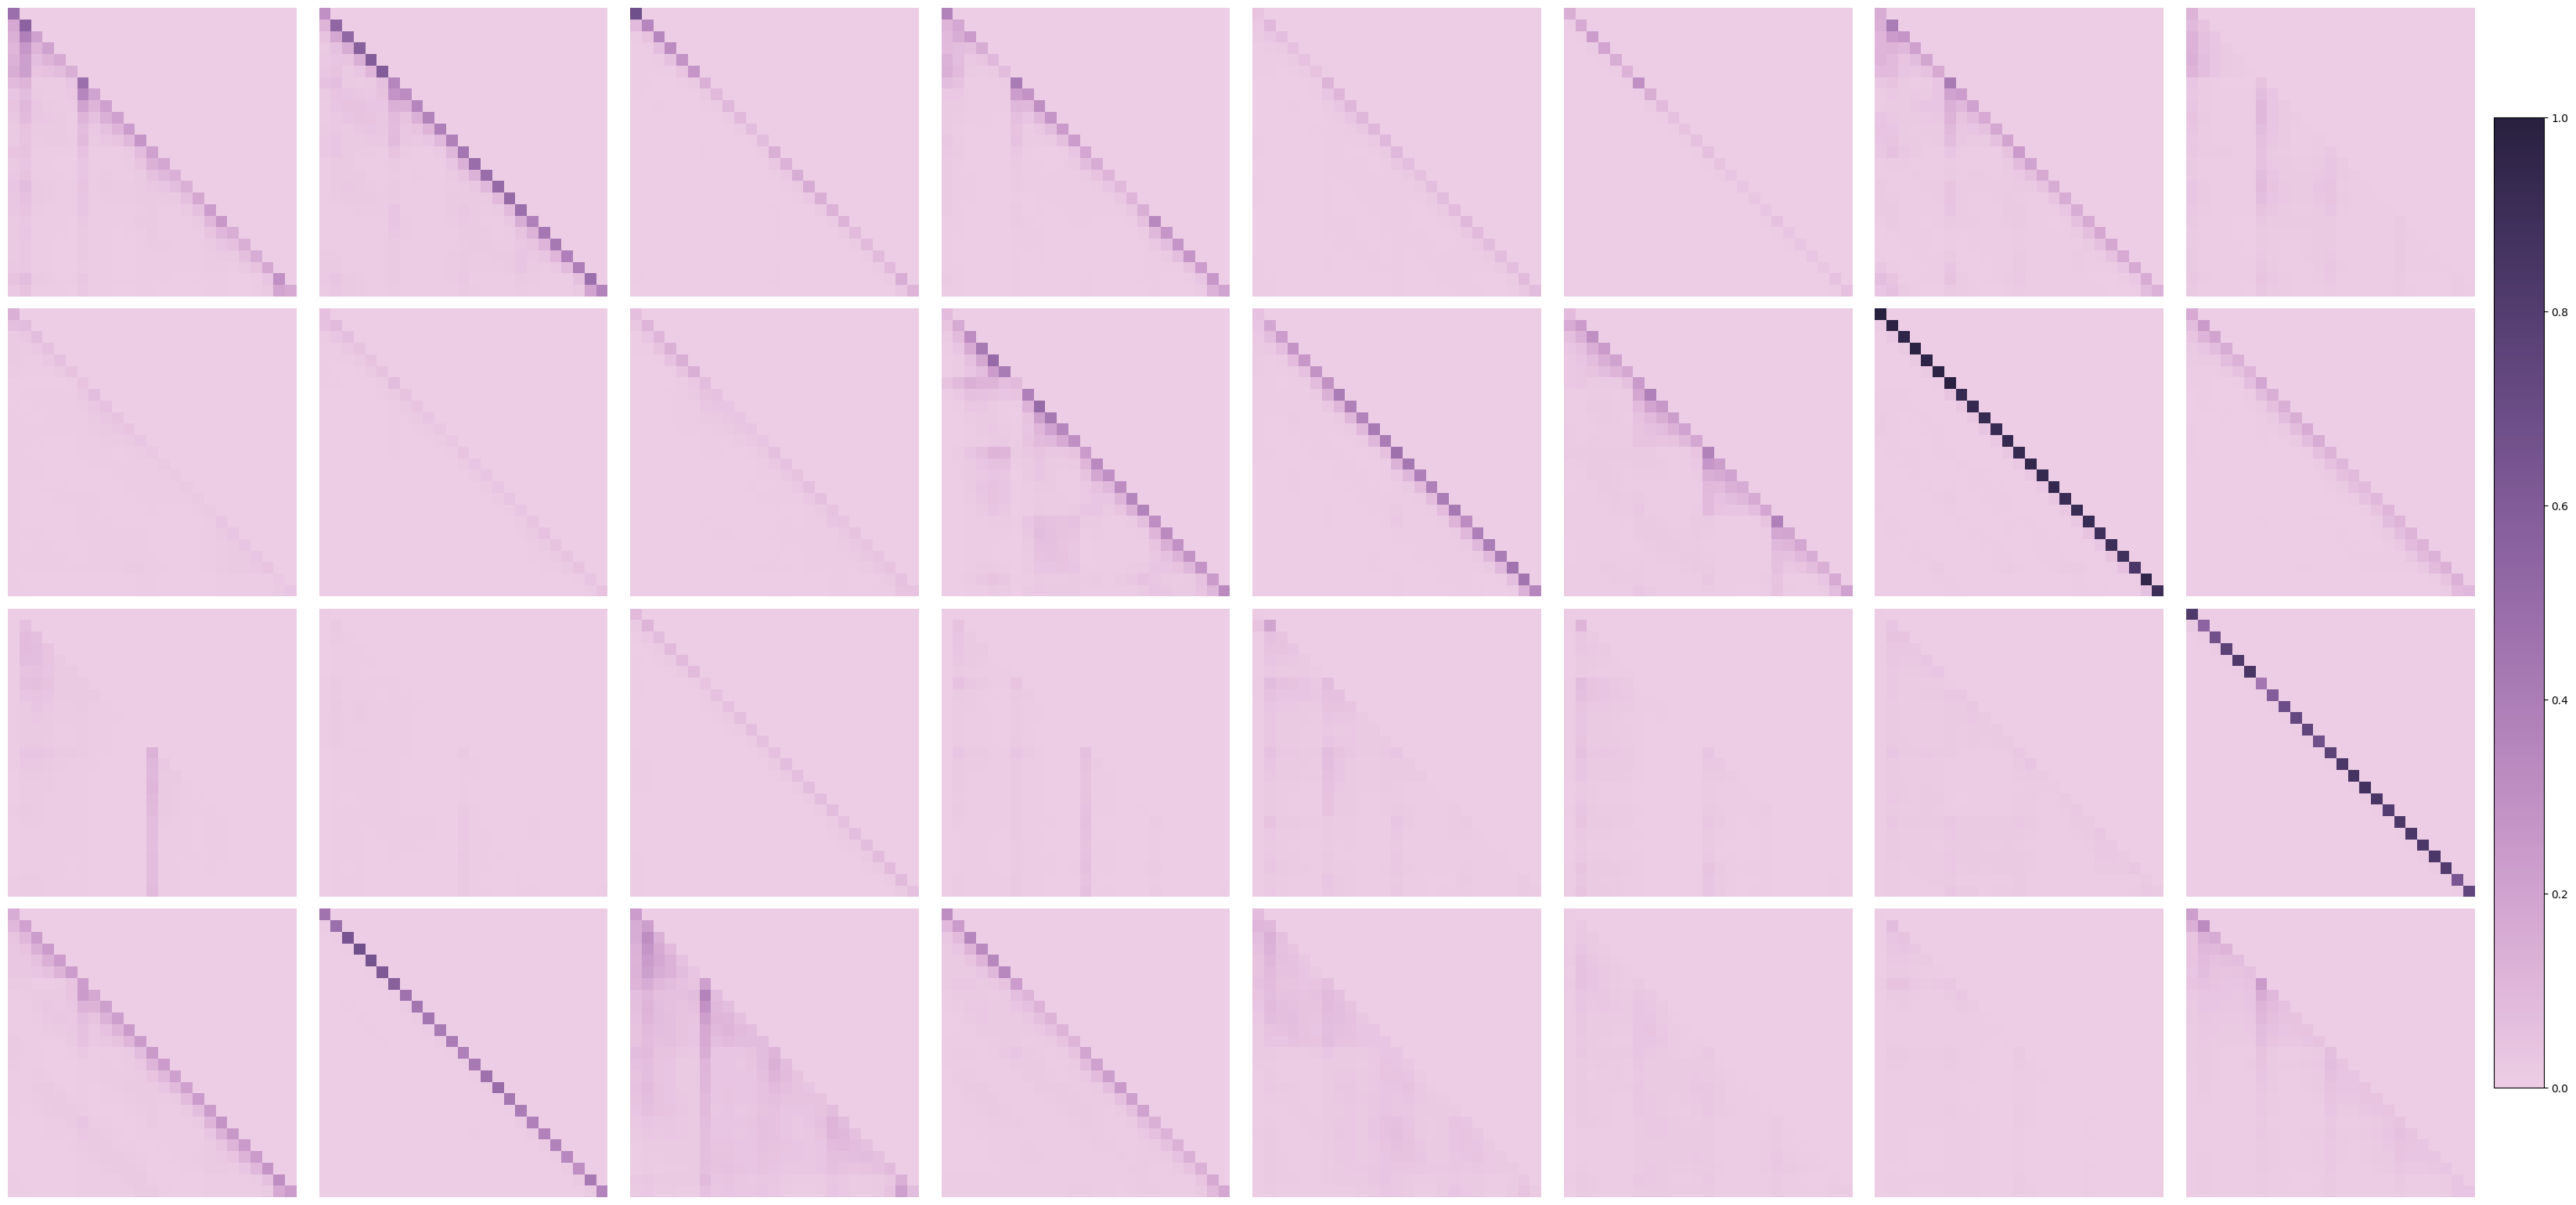

In [132]:
layer = -1

# Usage
plot_attention_matrices(attention_matrices=attention[layer][0,:,1:,1:].cpu().detach().numpy(), save=True)

### sum over heads

/tmp/ipykernel_2113408/1216259471.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


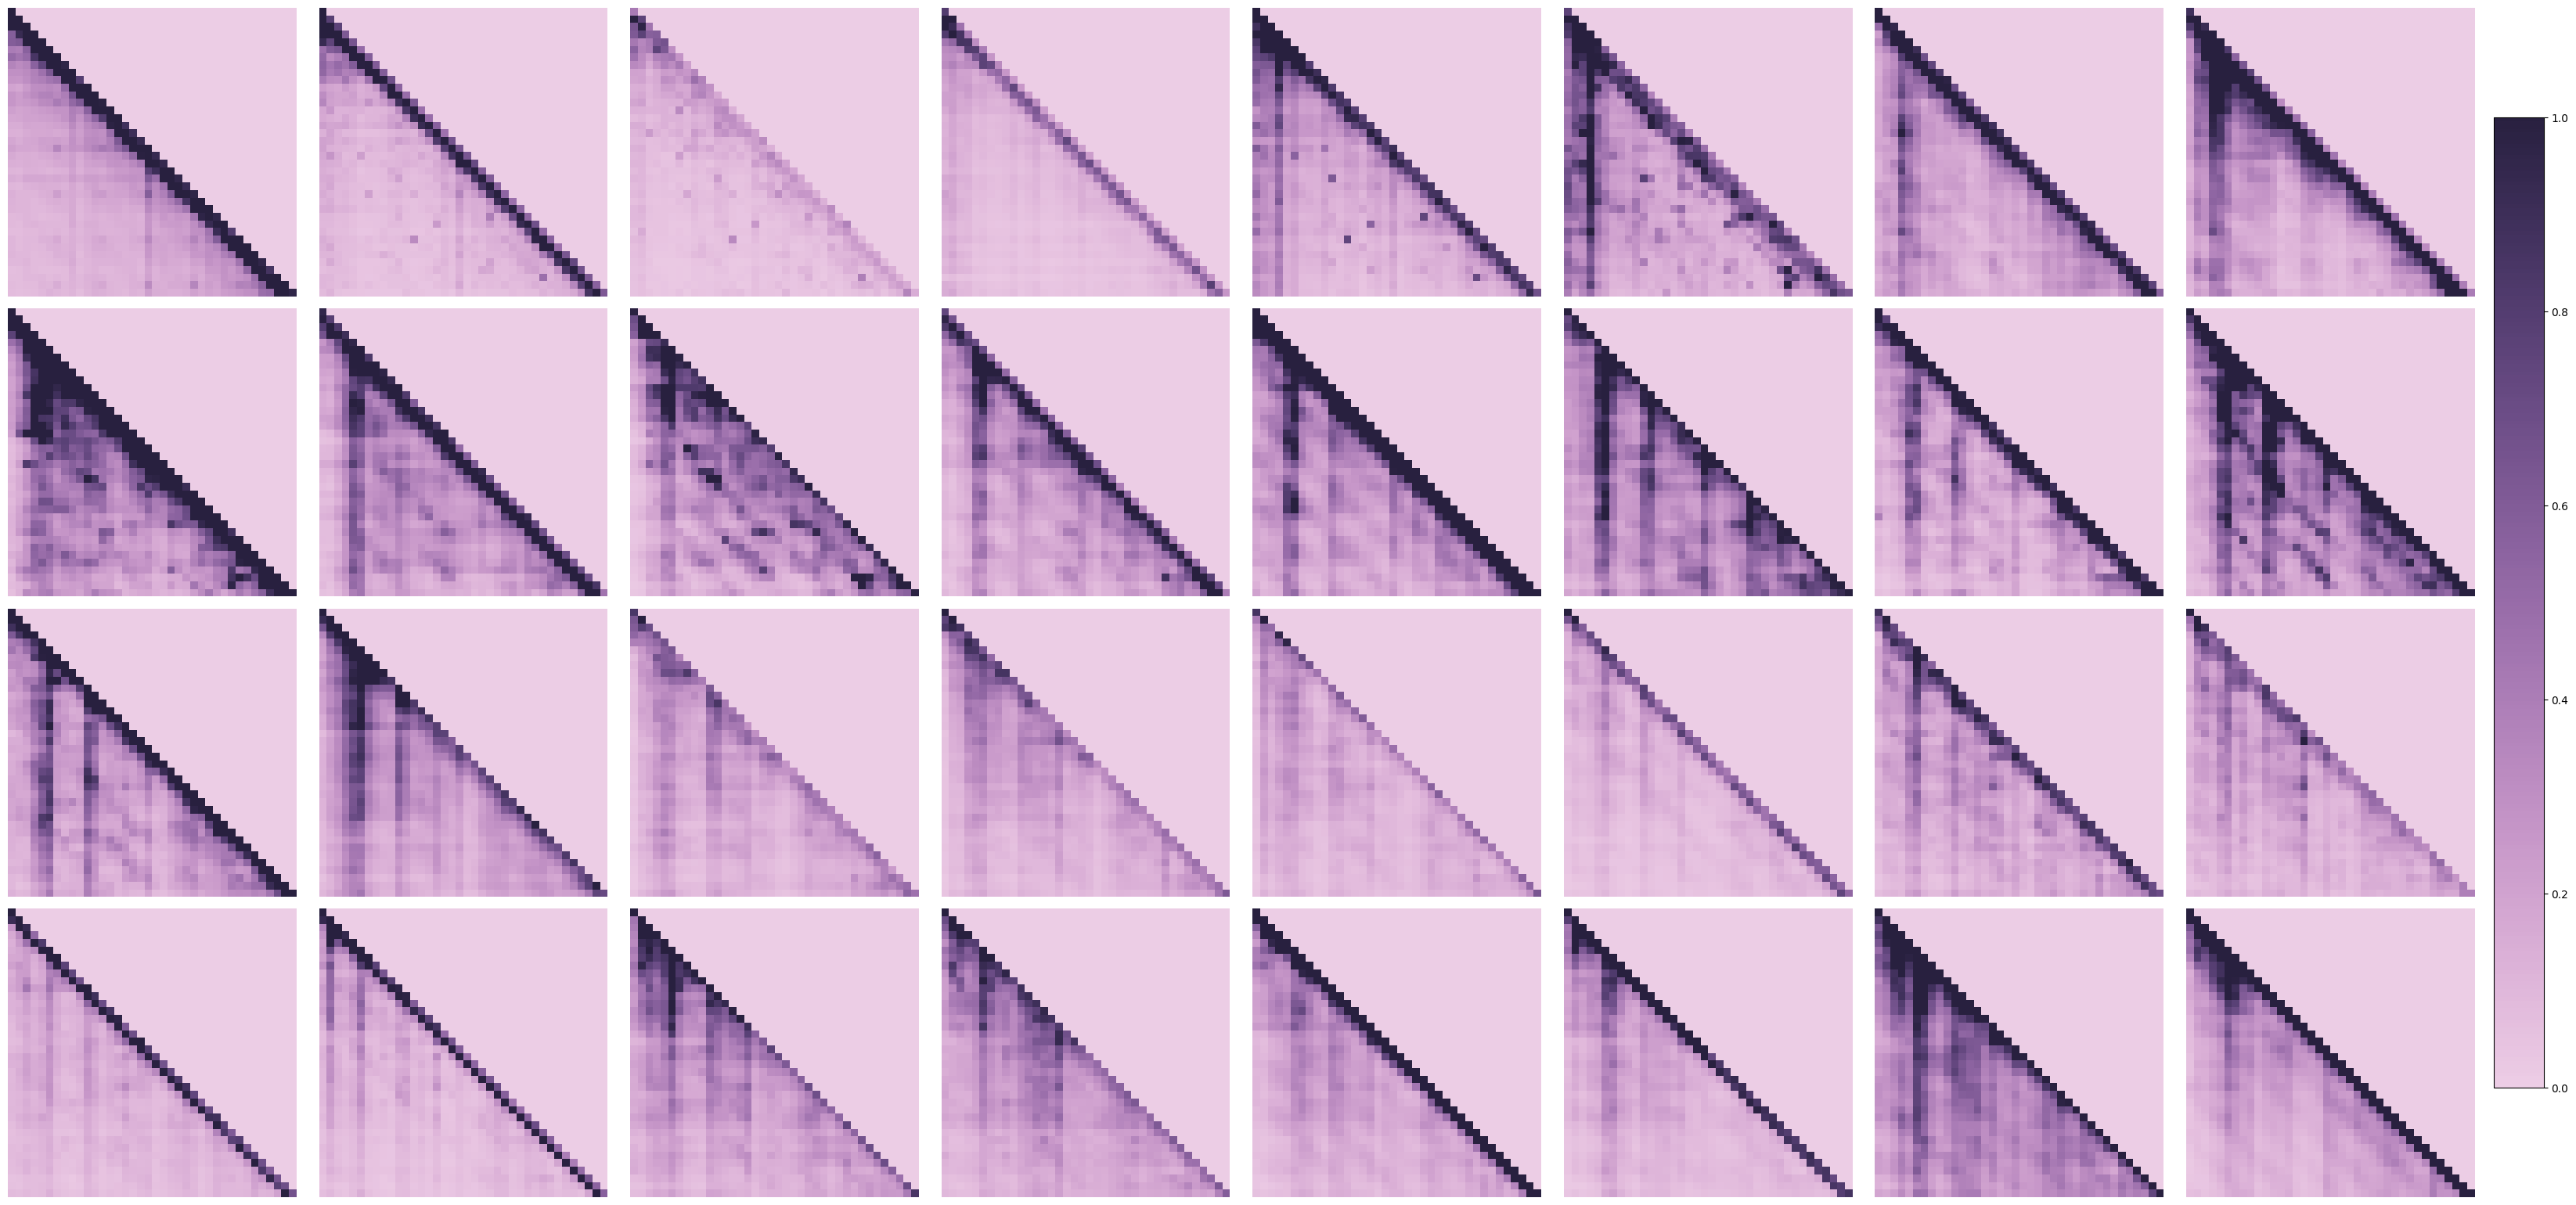

In [141]:
# Usage
plot_attention_matrices(attention_matrices=torch.concat(attention, axis=0)[:,:,1:,1:].cpu().detach().numpy().sum(axis=1), save=True)

## matrix of pairwise differences

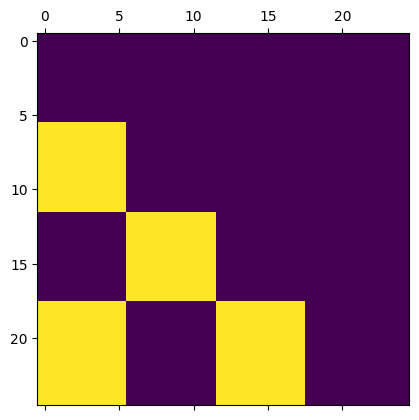

In [135]:
from sklearn.metrics.pairwise import pairwise_distances
pw_dist_matrix = pairwise_distances(np.array([float(s) for s in two_jump_series.split(',') if s])[..., None])
pw_dist_matrix *= np.tri(*pw_dist_matrix.shape)
plt.matshow(pw_dist_matrix)